# Building a Knowledge Graph (KG)

In [5]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

from controller import SmartAPI
from IPython.display import display

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

### Steps:
1. Get MetaKG API w/ and ID  
2. Clean the data for KG import  
3. Setup the KG  
4. Write to XML file  


### Get MetaKG API  
INPUT: need input ID

### 

In [6]:
bte = SmartAPI.get("dc91716f44207d2e1287c727f281d339")
mkg = bte.get_metakg()
mkg_df = pd.DataFrame(mkg)


In [7]:
mkg_df.sample()

,subject,object,predicate,provided_by,api,bte
232,Disease,Treatment,related_to,None,"{'name': 'BioThings Explorer (BTE) TRAPI', 'smartapi': {'metadata': 'https://raw.githubusercontent.com/NCATS-Tangerine/translator-api-registry/master/biothings_explorer/smartapi.yaml', 'id': 'dc91716f44207d2e1287c727f281d339', 'ui': 'https://smart-api.info/ui/dc91716f44207d2e1287c727f281d339'}, 'tags': ['1.3.0', 'meta_knowledge_graph', 'query', 'asyncquery', 'translator', 'trapi', 'biothings', 'bte-trapi'], 'x-translator': {'component': 'ARA', 'team': ['Exploring Agent']}}","{'query_operation': {'path': '/query', 'method': 'post', 'server': 'https://bte.transltr.io/v1', 'path_params': None, 'params': None, 'request_body': None, 'support_batch': True, 'input_separator': ','}}"


### Clean the dataframe for graph input  
We only need to keep the subject/object/predicate. 

In [8]:
mkg_df.drop(["provided_by"], axis=1, inplace=True)
mkg_df.drop(["api"], axis=1, inplace=True)
mkg_df.drop(["bte"], axis=1, inplace=True)

In [9]:
mkg_df.sample()

,subject,object,predicate
1,Pathway,Gene,has_participant


In [10]:
mkg_df["predicate"].unique()

array(['actively_involved_in', 'has_participant', 'has_input',
       'subclass_of', 'related_to', 'regulates', 'precedes', 'overlaps',
       'has_part', 'temporally_related_to', 'causes', 'superclass_of',
       'in_taxon', 'occurs_in', 'actively_involves', 'disrupts',
       'located_in', 'affects', 'treated_by', 'is_diagnosed_by',
       'caused_by', 'prevented_by', 'affected_by', 'preceded_by',
       'has_predisposing_factor', 'is_exacerbated_by', 'associated_with',
       'correlated_with', 'positively_correlated_with',
       'negatively_correlated_with', 'disrupted_by', 'produces',
       'has_contraindication', 'adverse_event_of',
       'occurs_together_in_literature_with', 'contribution_from',
       'coexists_with', 'predisposes', 'exacerbates', 'part_of',
       'manifestation_of', 'has_manifestation', 'location_of',
       'contains_process', 'contributes_to', 'similar_to',
       'has_phenotype', 'gene_associated_with_condition',
       'condition_associated_with_gene',

### Setup the KG with a networkx

In [11]:
import networkx as nx

Using the dataframe we created above, `mkg_df`, we can directly create a graph by importing a pandas dataframe into the networkx function.

In [12]:
# create a directed graph  -- all available relations 
G1=nx.from_pandas_edgelist(mkg_df, "subject", "object", edge_attr=True,create_using=nx.MultiDiGraph())

In [13]:
# create a directed graph  -- one relation
G2=nx.from_pandas_edgelist(mkg_df[mkg_df['predicate']=='derives_from'], "subject", "object", edge_attr=True,create_using=nx.MultiDiGraph())

In [14]:
# create a directed graph  -- one relation
G3=nx.from_pandas_edgelist(mkg_df[mkg_df['predicate']=='is_diagnosed_by'], "subject", "object", edge_attr=True,create_using=nx.MultiDiGraph())

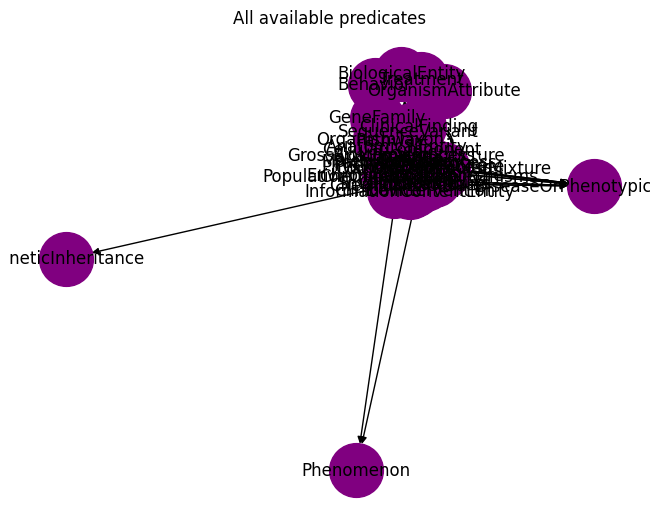

In [47]:
pos = nx.spring_layout(G1)
nx.draw(G1, with_labels=True, node_color='purple', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title("All available predicates")
plt.show()

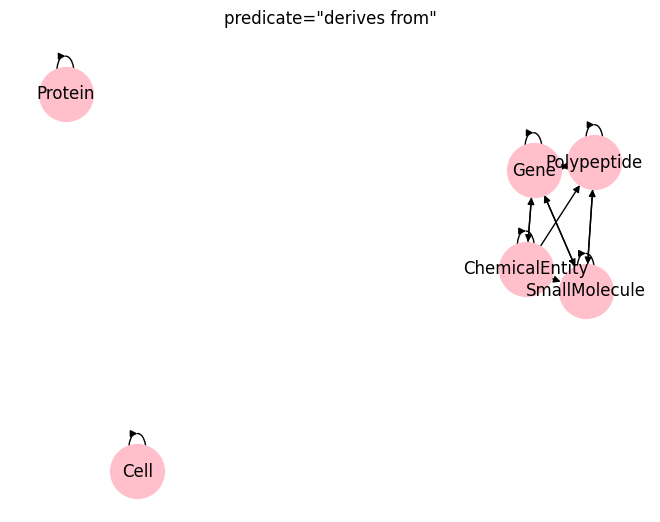

In [51]:
pos = nx.spring_layout(G2, k = 0.5) # k regulates the distance between nodes
nx.draw(G2, with_labels=True, node_color='pink', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('predicate="derives from"')
plt.show()


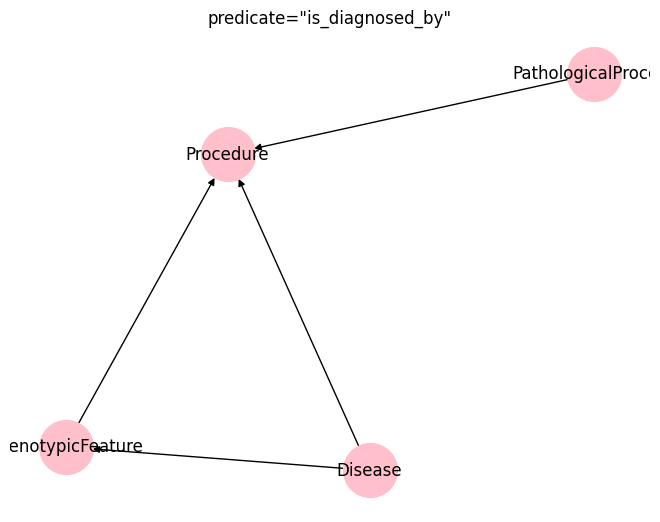

In [53]:
pos = nx.spring_layout(G3)#, k = 0.5) # k regulates the distance between nodes
nx.draw(G3, with_labels=True, node_color='pink', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('predicate="is_diagnosed_by"')
plt.show()


#### Generate the KG with a built-in package

In [50]:
import xml.etree.ElementTree as ET


In [26]:
# Create a new XML document
root = ET.Element("graph")
root

<Element 'graph' at 0x130afc450>

In [27]:
# Add nodes to the graph
nodes = set(mkg_df["subject"]) | set(mkg_df["object"])
for node in nodes:
    node_element = ET.SubElement(root, "node", id=node)


In [28]:
# Add edges to the graph
for _, row in mkg_df.iterrows():
    edge_element = ET.SubElement(root, "edge", source=row["subject"], target=row["object"], relation=row['predicate'])


In [29]:
tree = ET.ElementTree(root)
tree

In [30]:
# Write the XML document to a file
tree.write("graph.xml")


Generate a predicate specific graph

In [31]:
df_derives_from = mkg_df[mkg_df['predicate']=='derives_from']
df_derives_from.sample()

,subject,object,predicate
300,Gene,SmallMolecule,derives_from


In [32]:
# Create a new XML document
new_root2 = ET.Element("graph")

# Add nodes to the graph
nodes = set(df_derives_from["subject"]) | set(df_derives_from["object"])
for node in nodes:
    node_element = ET.SubElement(new_root2, "node", id=node)

# Add edges to the graph
for _, row in df_derives_from.iterrows():
    edge_element = ET.SubElement(new_root2, "edge", source=row["subject"], target=row["object"], relation=row['predicate'])
tree = ET.ElementTree(new_root2)
# Write the XML document to a file
tree.write("graph2.xml")



Testing the new `xml` file

In [33]:
# Create an empty graph
new_graph = nx.Graph()
new_graph2 = nx.Graph()
# Load the XML file
new_tree = ET.parse('graph.xml')
new_root = new_tree.getroot()
new_tree2 = ET.parse('graph2.xml')
new_root2 = new_tree2.getroot()

def fill_graph(graph,root):
    for child in root:
        if child.get('source'):
            source = child.get('source')
            target = child.get('target')
            relation = child.get('relation')
            # print(source, target, relation)
            graph.add_edge(source, target, relation=relation)

fill_graph(new_graph, new_root)
fill_graph(new_graph2, new_root2)


Graph the new tree

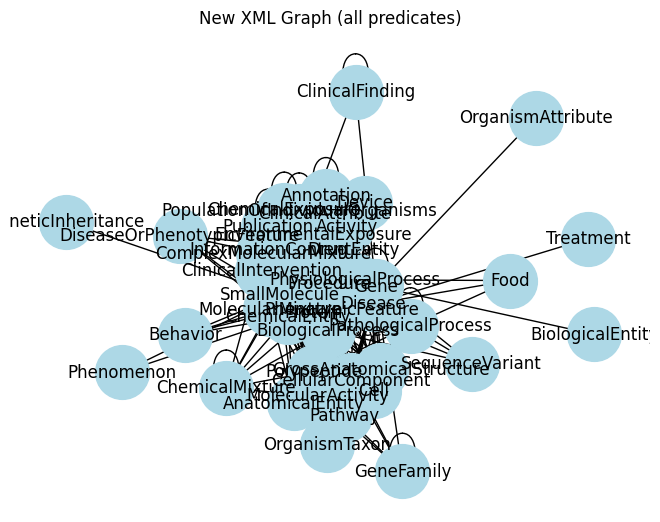

In [34]:
# Draw the graph using NetworkX and Matplotlib
pos = nx.spring_layout(new_graph)
# nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=500)
# nx.draw_networkx_edges(graph, pos, edge_color='gray')
# nx.draw_networkx_labels(graph, pos, font_size=10, font_family='Arial')
# nx.draw_networkx_edge_labels(graph, pos, font_size=8, font_family='Arial')
nx.draw(new_graph, with_labels=True, node_color='lightblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('New XML Graph (all predicates)')
plt.axis('off')
plt.show()

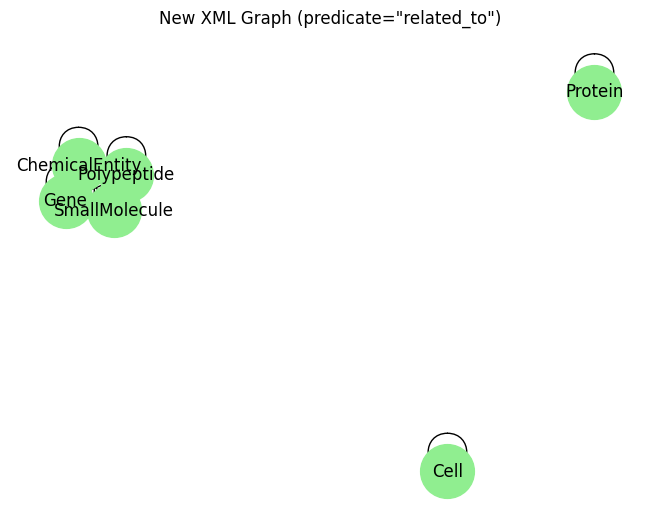

In [35]:
# Draw the graph using NetworkX and Matplotlib
pos = nx.spring_layout(new_graph2)
nx.draw(new_graph2, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title('New XML Graph (predicate="related_to")')
plt.axis('off')
plt.show()

---